### RESEARCH ON DATA FROM https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


#### IMPORTED PACKAGES

In [249]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import ast
from itertools import chain

#### UTIL FUNCTIONS

In [101]:
def print_df(df):
    with pd.option_context("display.max_columns", None):
        display(df.head(2))
        
def random_color():
    return "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

#### DATA LOADING AND BASIC PREPROCESSING

- Load the dataset

In [239]:
# suppress warnings
meta_data_df = pd.read_csv("../data/movies_metadata.csv", low_memory=False)

- Drop meaningless columns

In [242]:
dropped_columns =  ["homepage", "imdb_id", "poster_path", "status", "tagline"]
meta_data_df = meta_data_df.drop(columns=dropped_columns)

- Population coercion

In [241]:
# convert the popularity to numeric values, NaN (missing values) if can't convert
meta_data_df["popularity"] = pd.to_numeric(meta_data_df["popularity"], errors="coerce")

- Adult: convert to true/false value and remove noise

In [244]:
meta_data_df["adult"].value_counts()

meta_data_df["adult"] = meta_data_df["adult"].astype(str).str.strip().str.lower()

meta_data_df["adult"] = meta_data_df["adult"].map({
    "true": True,
    "false": False
})

meta_data_df["adult"] = meta_data_df["adult"].fillna(True)

/tmp/ipykernel_12160/3446648582.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  meta_data_df["adult"] = meta_data_df["adult"].fillna(True)


- Production countries, fill na with a simple empty list of countries

In [245]:
meta_data_df["production_countries"] = meta_data_df["production_countries"].fillna(value="[]")
# convert strings to python dict
meta_data_df['production_countries'] = meta_data_df['production_countries'].apply(ast.literal_eval)
# convert to a list of names of the countries
meta_data_df['country_names'] = meta_data_df['production_countries'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Genre generation

In [272]:
# convert str into python's dict
meta_data_df["genres"] = meta_data_df["genres"].apply(ast.literal_eval)
# convert to a list of genres
meta_data_df['genre_names'] = meta_data_df['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Convert datetime into datetime type for manageble

In [313]:
# can convert -> Nan
meta_data_df['release_date'] = pd.to_datetime(meta_data_df['release_date'], errors='coerce')

- Final data frame

In [314]:
meta_data_df.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
id                           0
original_language           11
original_title               0
overview                   954
popularity                   6
production_companies         3
production_countries         0
release_date                90
revenue                      6
runtime                    263
spoken_languages             6
title                        6
video                        6
vote_average                 6
vote_count                   6
country_names                0
genre_names                  0
dtype: int64

#### VISUALISE THE DATA

- budget: Most of the values are 0

In [169]:
meta_data_df["budget"].value_counts()

budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
12200000        1
65700           1
64200           1
707503          1
8620000         1
Name: count, Length: 1226, dtype: int64

- revenue: Most of the revenue are 0

In [170]:
meta_data_df["revenue"].value_counts()

revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
100000.0          1
15073942.0        1
2807854.0         1
1942423.0         1
23833131.0        1
Name: count, Length: 6863, dtype: int64

- popularity values

In [172]:
meta_data_df["popularity"].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [48]:
(meta_data_df["popularity"] > 30).sum()

np.int64(111)

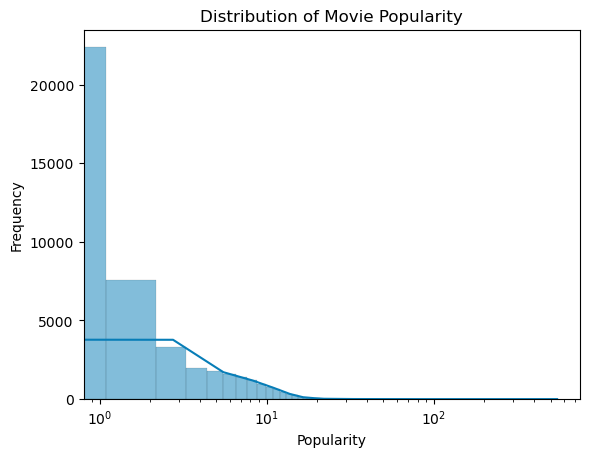

In [157]:
sns.histplot(meta_data_df["popularity"], bins=500, kde=True, color=random_color())

plt.xscale("log")
plt.title("Distribution of Movie Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()


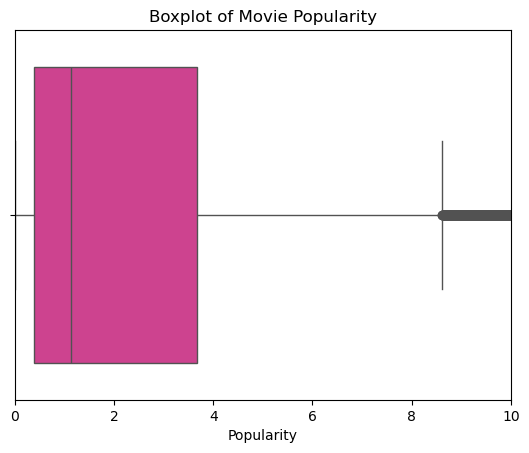

In [114]:
sns.boxplot(x=meta_data_df["popularity"], color=random_color())
plt.xlim((0, 10))
plt.title("Boxplot of Movie Popularity")
plt.xlabel("Popularity")
plt.show()


- runtime of the movies

In [174]:
meta_data_df["runtime"].describe()

count    45203.000000
mean        94.128199
std         38.407810
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

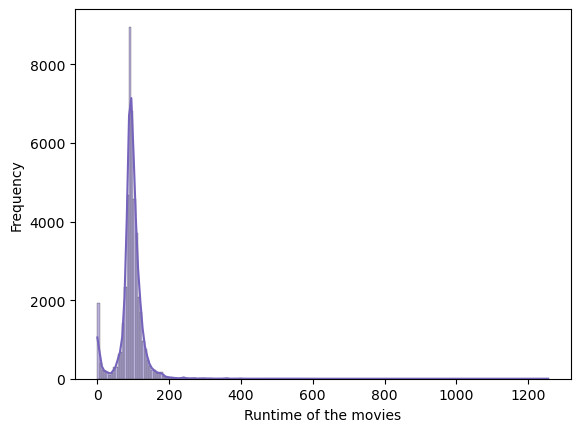

In [188]:
sns.histplot(data=meta_data_df, x="runtime", color=random_color(), bins=200, kde=True)

plt.xlabel("Runtime of the movies")
plt.ylabel("Frequency")
plt.show()

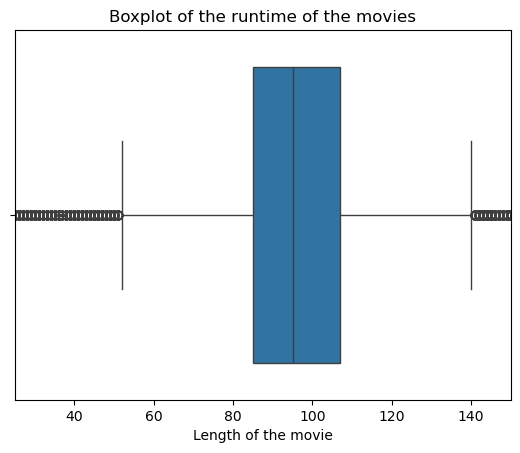

In [186]:
sns.boxplot(data=meta_data_df, x="runtime")

plt.xlim((25, 150))
plt.xlabel("Length of the movie")
plt.title("Boxplot of the runtime of the movies")
plt.show()

- Changes of runtime

In [317]:
# only used to view the change in runtime
meta_date = meta_data_df[meta_data_df["release_date"].notna()]

In [330]:
meta_date['year'] = meta_date['release_date'].dt.year
year_runtime = meta_date.groupby('year')['runtime'].mean().reset_index()

/tmp/ipykernel_12160/687814297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_date['year'] = meta_date['release_date'].dt.year


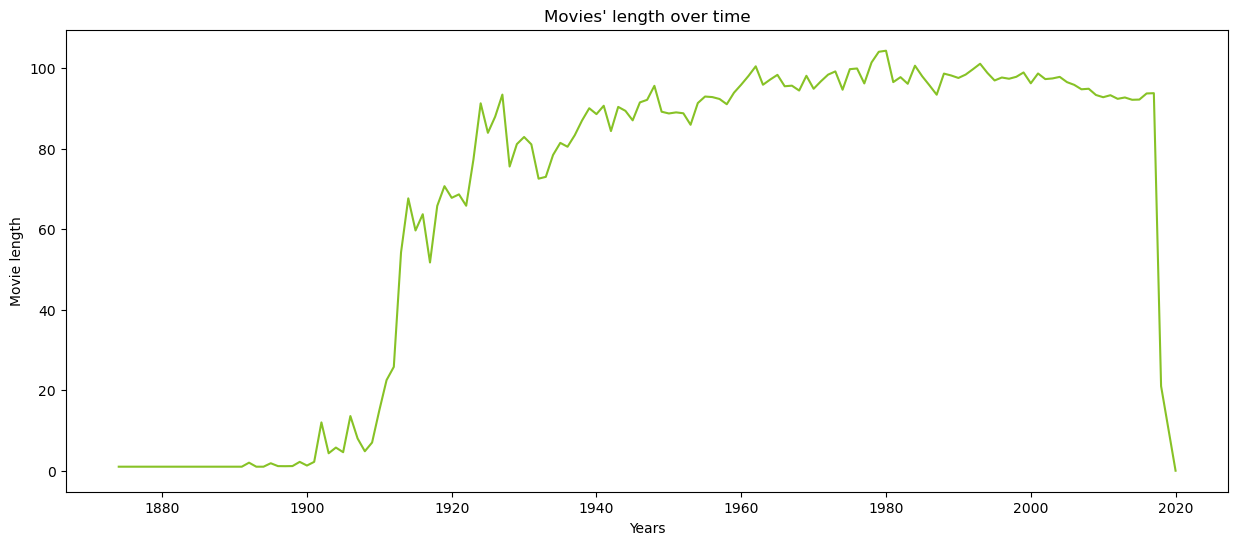

In [341]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=year_runtime, x="year", y="runtime", color=random_color())

plt.xlabel("Years")
plt.ylabel("Movie length")
plt.title("Movies' length over time")
plt.show()

- vote average: nearly normally distributed with mean 5.6?

In [80]:
meta_data_df["vote_average"].describe()

count    45460.000000
mean         5.618207
std          1.924216
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

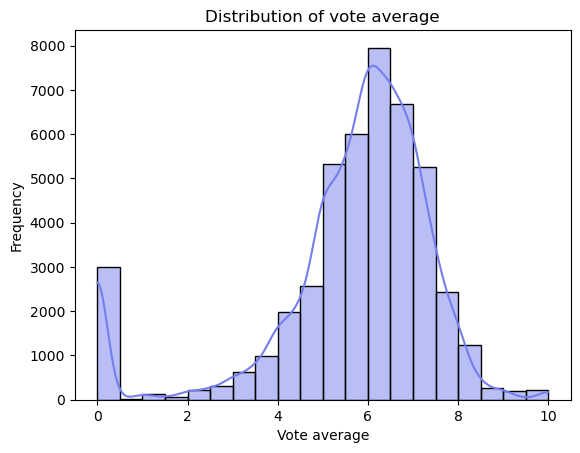

In [115]:
sns.histplot(meta_data_df["vote_average"], bins=20, kde=True, color=random_color())

plt.title("Distribution of vote average")
plt.xlabel("Vote average")
plt.ylabel("Frequency")
plt.show()

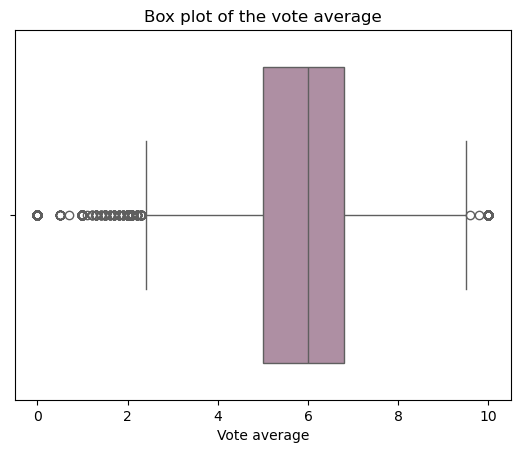

In [116]:
sns.boxplot(x=meta_data_df["vote_average"], color=random_color())

plt.xlabel("Vote average")
plt.title("Box plot of the vote average")
plt.show()

- vote_count, not so usefull as the number of vote is too small

In [83]:
meta_data_df["vote_count"].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [131]:
(meta_data_df["vote_count"] > 100).sum()

np.int64(6020)

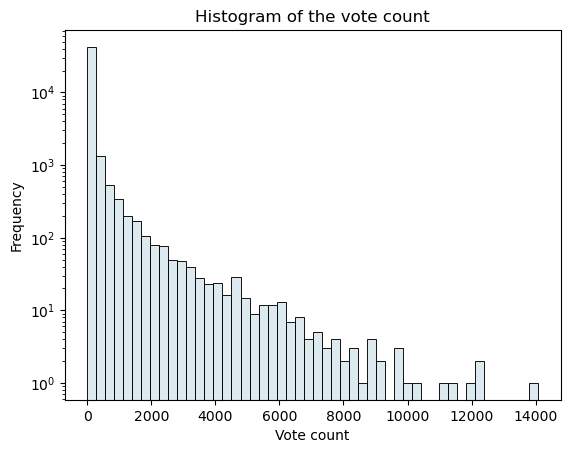

In [151]:
sns.histplot(data=meta_data_df, x="vote_count", bins=50, color=random_color())

plt.yscale("log")
plt.xlabel("Vote count")
plt.ylabel("Frequency")
plt.title("Histogram of the vote count")
plt.show()

- Most movies have very few votes, but some have high votes 10000

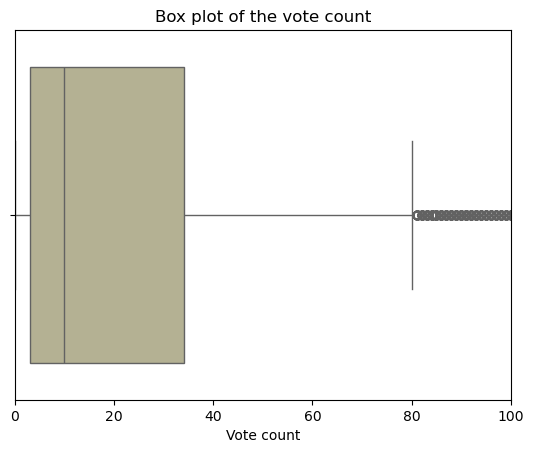

In [130]:
sns.boxplot(data=meta_data_df, x="vote_count", color=random_color())

plt.xlim((0, 100))
plt.xlabel("Vote count")
plt.title("Box plot of the vote count")
plt.show()

- Countries that produce the movies

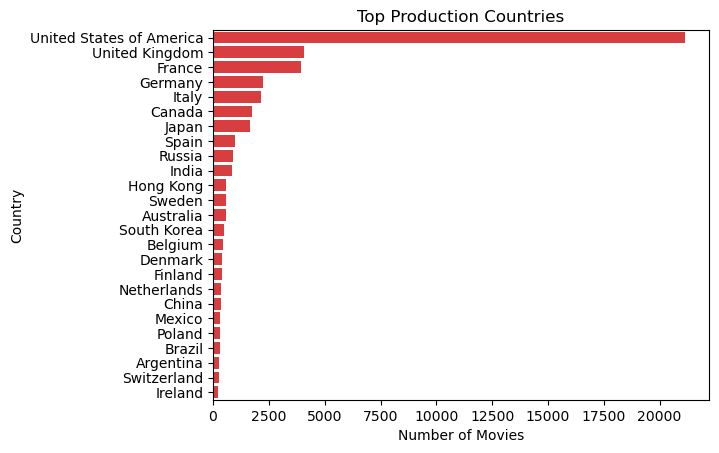

In [262]:
country_counts = pd.Series(list(chain.from_iterable(meta_data_df['country_names']))).value_counts()
top_countries = country_counts.head(25)

sns.barplot(x=top_countries.values, y=top_countries.index, color=random_color())  
plt.title("Top Production Countries")
plt.xlabel("Number of Movies")
plt.ylabel("Country")
plt.show()

- Genre calculation

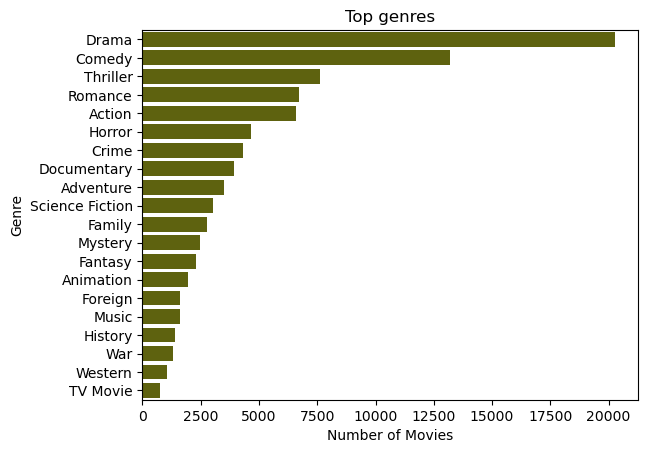

In [277]:
genre_counts = pd.Series(list(chain.from_iterable(meta_data_df['genre_names']))).value_counts()
top_genres = genre_counts.head(20)

sns.barplot(x=top_genres.values, y=top_genres.index, color=random_color())  
plt.title("Top genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()